In [1]:
import os
import struct

import numpy as np
import tensorflow as tf
tf.disable_v2_behavior() # TensorFlowを1系ライクに扱う
import keras

/Users/irieyoshiki/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/irieyoshiki/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/irieyoshiki/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/irieyoshiki/.local/lib/python3.7/site-packages/tensorflow/python/f

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Layers APIを使って多層ニューラルネットワークを構築する

TensorFlowの高レベルAPIである`tensorflow.layers`によってニューラルネットワークを構築する。前のページで定義されていた`load_mnist`を使って読み込んで前処理をしてみる。

In [2]:
def load_mnist(path, kind='train'):
    # パスを結合してロード, gzip形式でロード
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # ラベルを読み込む
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換, 8バイト分を指定してマジックナンバー, アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    # 画像を読み込む
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        # 画像ピクセル情報の配列サイズを変更
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
        
    return images, labels

In [3]:
# train, testをそれぞれロード
X_train, y_train = load_mnist('.', kind='train')
X_test, y_test = load_mnist('.', kind='t10k')

# 標準化と正規化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

# 使わなくなったデータは削除してメモリを節約する
del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


ここから実際にモデル構築を行う。

## 1. プレースホルダの作成、全結合層の定義
`tf_x`と`tf_y`の2つのプレースホルダを作成して、全結合層を3つ定義する。なお$\tanh$関数と$softmax$関数については次節に説明を任せる。

In [4]:
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    
    # 入力層
    tf_x = tf.placeholder(dtype=tf.float32,
                          shape=(None, n_features),
                          name='tf_x')
    # 出力層
    tf_y = tf.placeholder(dtype=tf.int32,
                          shape=None,
                          name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    
    # 隠れ層
    h1 = tf.layers.dense(inputs=tf_x,
                         units=50,
                         activation=tf.tanh,
                         name='layer1')
    h2 = tf.layers.dense(inputs=h1,
                         units=50,
                         activation=tf.tanh,
                         name='layer2')
    logits = tf.layers.dense(inputs=h2,
                             units=10,
                             activation=None,
                             name='layer3')
    
    predictions = {
        'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits, name='softmax_tensor')
    }

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


次にコスト関数とオプティマイザの定義を行う。

In [5]:
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot,
                                           logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss=cost)
    init_op = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


その後、実際に学習する前にはデータバッチが必要となるのでバッチを作成する関数を定義する。呼び出すたびに新しいバッチを生成するようにジェネレータとして定義する。

In [6]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

TensorFlow1系ではセッションを作成(計算グラフを起動する)してニューラルネットワークを初期化した後に学習を開始する。学習途中にエポック毎の学習プロセスを監視して、トレーニングの平均損失率も表示する。

In [7]:
sess = tf.Session(graph=g)
sess.run(init_op)

# 50epochのトレーニング
training_costs = []
for epoch in range(50):
    training_loss = []
    batch_generator = create_batch_generator(X_train_centered, y_train, batch_size=64)
    
    for batch_X, batch_y in batch_generator:
        feed = {tf_x: batch_X, tf_y: batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
        
    print('Epoch %2d Avg. Trainging Loss: %.4f' % (epoch+1, np.mean(training_costs)))

Epoch  1 Avg. Trainging Loss: 1.5573
Epoch  2 Avg. Trainging Loss: 1.2532
Epoch  3 Avg. Trainging Loss: 1.0854
Epoch  4 Avg. Trainging Loss: 0.9738
Epoch  5 Avg. Trainging Loss: 0.8924
Epoch  6 Avg. Trainging Loss: 0.8296
Epoch  7 Avg. Trainging Loss: 0.7794
Epoch  8 Avg. Trainging Loss: 0.7381
Epoch  9 Avg. Trainging Loss: 0.7032
Epoch 10 Avg. Trainging Loss: 0.6734
Epoch 11 Avg. Trainging Loss: 0.6475
Epoch 12 Avg. Trainging Loss: 0.6247
Epoch 13 Avg. Trainging Loss: 0.6045
Epoch 14 Avg. Trainging Loss: 0.5864
Epoch 15 Avg. Trainging Loss: 0.5700
Epoch 16 Avg. Trainging Loss: 0.5551
Epoch 17 Avg. Trainging Loss: 0.5415
Epoch 18 Avg. Trainging Loss: 0.5290
Epoch 19 Avg. Trainging Loss: 0.5175
Epoch 20 Avg. Trainging Loss: 0.5068
Epoch 21 Avg. Trainging Loss: 0.4968
Epoch 22 Avg. Trainging Loss: 0.4875
Epoch 23 Avg. Trainging Loss: 0.4788
Epoch 24 Avg. Trainging Loss: 0.4706
Epoch 25 Avg. Trainging Loss: 0.4629
Epoch 26 Avg. Trainging Loss: 0.4556
Epoch 27 Avg. Trainging Loss: 0.4487
E

In [8]:
# 最後に予測してみる
feed = {tf_x: X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)

print('Test Accuracy: %.2f%%' % (100 * np.sum(y_pred == y_test) / y_test.shape[0]))

Test Accuracy: 93.89%


# Kerasを使って多層ニューラルネットワークを開発する

KerasはTensorFlowの高レベルAPIの1つである。Kerasの主たる機能は`Sequential`モデルというレイヤーの線形スタックを構成するモデルである。

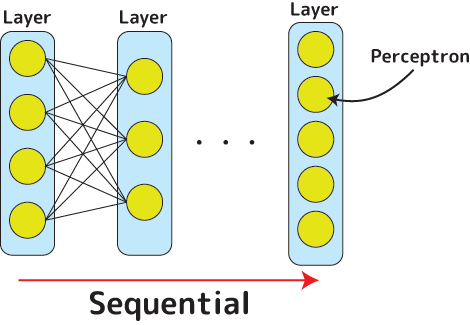

In [9]:
from IPython.display import Image
Image("./ch13_image1.gif")

先ほどのモデルをKerasで実装すると、以下のようになる。

In [10]:
# もう一度train, testをそれぞれロード
X_train, y_train = load_mnist('.', kind='train')
X_test, y_test = load_mnist('.', kind='t10k')

# 標準化と正規化
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

# 使わなくなったデータは削除してメモリを節約する
del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [11]:
# keras.utils.to_categoricalでone-hot表現にする
y_train_onehot = tf.keras.utils.to_categorical(y_train)

Kerasはモデルを直感的に定義できるのが利点であり、初期化、層の追加、オプティマイザの設定の後にコンパイルする。

In [12]:
# モデルの初期化
model = keras.models.Sequential()

# 1つ目の隠れ層
model.add(keras.layers.Dense(units=50,
                             input_dim=X_train_centered.shape[1],
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros',
                             activation='tanh'))

# 2つ目の隠れ層
model.add(keras.layers.Dense(units=50,
                      input_dim=50,
                      kernel_initializer='glorot_uniform',
                      bias_initializer='zeros',
                      activation='tanh'))

# 出力層
model.add(keras.layers.Dense(units=y_train_onehot.shape[1],
                             input_dim=50,
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros',
                             activation='softmax'))

# オプティマイザの設定, 学習率, 荷重減衰率, モーメンタム学習を設定
sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=.9)

# モデルのコンパイル
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')

学習についても`model.fit`で簡単に行え、historyの表示もしてくれる。

In [13]:
history = model.fit(X_train_centered,
                    y_train_onehot,
                    batch_size=64,
                    epochs=50,
                    verbose=1,            # メッセージ出力
                    validation_split=0.1) # 検証用データの割合

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s 28us/step - loss: 0.7247 - val_loss: 0.3621
Epoch 2/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.3657 - val_loss: 0.2718
Epoch 3/50
54000/54000 [==============================] - 1s 24us/step - loss: 0.2970 - val_loss: 0.2331
Epoch 4/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2604 - val_loss: 0.2105
Epoch 5/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2353 - val_loss: 0.1930
Epoch 6/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2162 - val_loss: 0.1807
Epoch 7/50
54000/54000 [==============================] - 1s 25us/step - loss: 0.2006 - val_loss: 0.1718
Epoch 8/50
54000/54000 [==============================] - 1s 26us/step - loss: 0.1877 - val_loss: 0.1634
Epoch 9/50
54000/54000 [==============================] - 1s 25

In [14]:
# 正解率の出力
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test_centered, verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Training accuracy: 98.98%
Test accuracy: 96.10%
